**Install requirements**

In [0]:

!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'


     |████████████████████████████████| 753.4MB 21kB/s 
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
     |████████████████████████████████| 4.0MB 2.9MB/s 
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 634kB 2.9MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110294 sha256=d3d1b1ca1aa44e4407267d90945d799e89f74b9244c82461f0ae23badb9b4457
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 3e-2           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [24]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

"""train_len = int(train_dataset.__len__() / 2)
val_len = train_dataset.__len__() - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])"""

y_true = train_dataset.get_labels()
train_idx, val_idx = train_test_split(np.arange(train_dataset.__len__()), train_size=.5, stratify=y_true)

val_dataset = Subset(train_dataset, val_idx)
train_dataset = Subset(train_dataset, train_idx)

# Check dataset sizes
print(f"# classes train_set: {len(set(y_true[train_idx]))}")
print(f"# classes val_set: {len(set(y_true[val_idx]))}")
print(f"# classes test_set: {len(set(test_dataset.get_labels()))}")
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


# classes train_set: 101
# classes val_set: 101
# classes test_set: 101
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
def evaluate(data_loader, model):
  model.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(data_loader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = model(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))
  return accuracy

**Train**

In [52]:
# List to store every loss of each step.
losses = []
accuracies = []
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  cumulative_loss = .0
  # Iterate over the dataset
  for images, labels in train_dataloader:
  
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    cumulative_loss += loss.item()

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}, Cumulative {}'.format(current_step, loss.item(), cumulative_loss))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Avg of cumulative loss
  losses.append(cumulative_loss / len(train_dataloader))
  # Evaluation on validation_set
  accuracies.append(evaluate(val_dataloader, net))
  # Step the scheduler
  scheduler.step() 

print("\n************ END OF TRAINING ***************")

Starting epoch 1/30, LR = [0.03]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.616384983062744, Cumulative 4.616384983062744


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 4.585736274719238, Cumulative 50.64343023300171


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]

Validation Accuracy: 0.09232365145228216
Starting epoch 2/30, LR = [0.03]


Step 20, Loss 4.508924961090088, Cumulative 45.45167589187622


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.09197786998616875
Starting epoch 3/30, LR = [0.03]


Step 30, Loss 4.359563827514648, Cumulative 39.26683187484741


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.09232365145228216
Starting epoch 4/30, LR = [0.03]


Step 40, Loss 4.276922225952148, Cumulative 33.76752519607544


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Validation Accuracy: 0.09197786998616875
Starting epoch 5/30, LR = [0.03]


Step 50, Loss 4.232882499694824, Cumulative 29.130245208740234


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.13658367911479943
Starting epoch 6/30, LR = [0.03]


Step 60, Loss 4.102151870727539, Cumulative 24.566367387771606


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]

Validation Accuracy: 0.10684647302904564
Starting epoch 7/30, LR = [0.03]


Step 70, Loss 4.143257141113281, Cumulative 20.25577449798584


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.17289073305670816
Starting epoch 8/30, LR = [0.03]


Step 80, Loss 4.002209663391113, Cumulative 15.819849014282227


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Validation Accuracy: 0.20677731673582295
Starting epoch 9/30, LR = [0.03]


Step 90, Loss 3.761486053466797, Cumulative 11.34276032447815


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.21473029045643152
Starting epoch 10/30, LR = [0.03]


Step 100, Loss 3.8547399044036865, Cumulative 7.325180292129517


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Validation Accuracy: 0.20193637621023514
Starting epoch 11/30, LR = [0.03]


Step 110, Loss 3.677422285079956, Cumulative 3.677422285079956
Step 120, Loss 3.4984664916992188, Cumulative 39.78746461868286


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Validation Accuracy: 0.23616874135546334
Starting epoch 12/30, LR = [0.03]


Step 130, Loss 3.3043363094329834, Cumulative 34.66240334510803


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Validation Accuracy: 0.2572614107883817
Starting epoch 13/30, LR = [0.03]


Step 140, Loss 3.4530067443847656, Cumulative 30.574244499206543


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]

Validation Accuracy: 0.2773167358229599
Starting epoch 14/30, LR = [0.03]


Step 150, Loss 3.3002243041992188, Cumulative 25.65544843673706


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Validation Accuracy: 0.2793914246196404
Starting epoch 15/30, LR = [0.03]


Step 160, Loss 3.0948493480682373, Cumulative 21.837642669677734


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]

Validation Accuracy: 0.30567081604426005
Starting epoch 16/30, LR = [0.03]


Step 170, Loss 3.0310752391815186, Cumulative 18.03864097595215


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Validation Accuracy: 0.3309128630705394
Starting epoch 17/30, LR = [0.03]


Step 180, Loss 2.8772857189178467, Cumulative 13.927040100097656


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Validation Accuracy: 0.33195020746887965
Starting epoch 18/30, LR = [0.03]


Step 190, Loss 2.4009716510772705, Cumulative 10.682238340377808


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.35200553250345784
Starting epoch 19/30, LR = [0.03]


Step 200, Loss 2.633578300476074, Cumulative 7.927908182144165


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.3924619640387275
Starting epoch 20/30, LR = [0.03]


Step 210, Loss 2.2595903873443604, Cumulative 4.540104866027832


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.35200553250345784
Starting epoch 21/30, LR = [0.00030000000000000003]


Step 220, Loss 2.164426803588867, Cumulative 2.164426803588867
Step 230, Loss 1.9730929136276245, Cumulative 22.69421100616455


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]

Validation Accuracy: 0.42773167358229597
Starting epoch 22/30, LR = [0.003]


Step 240, Loss 2.029019594192505, Cumulative 18.92300772666931


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]

Validation Accuracy: 0.43948824343015214
Starting epoch 23/30, LR = [0.003]


Step 250, Loss 1.9586114883422852, Cumulative 16.271093130111694


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Validation Accuracy: 0.448478561549101
Starting epoch 24/30, LR = [0.003]


Step 260, Loss 1.770808219909668, Cumulative 13.565319180488586


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]

Validation Accuracy: 0.44778699861687415
Starting epoch 25/30, LR = [0.003]


Step 270, Loss 1.6889668703079224, Cumulative 11.402833104133606


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]

Validation Accuracy: 0.45504840940525587
Starting epoch 26/30, LR = [0.003]


Step 280, Loss 1.612231969833374, Cumulative 9.80754280090332


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

Validation Accuracy: 0.4578146611341632
Starting epoch 27/30, LR = [0.003]


Step 290, Loss 1.377275824546814, Cumulative 7.482907652854919


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Validation Accuracy: 0.46092669432918393
Starting epoch 28/30, LR = [0.003]


Step 300, Loss 1.4754878282546997, Cumulative 6.079611539840698


100%|██████████| 12/12 [00:07<00:00,  1.69it/s]

Validation Accuracy: 0.46887966804979253
Starting epoch 29/30, LR = [0.003]


Step 310, Loss 1.2832365036010742, Cumulative 4.049407958984375


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Validation Accuracy: 0.4602351313969571
Starting epoch 30/30, LR = [0.003]


Step 320, Loss 1.2900763750076294, Cumulative 2.6769258975982666


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Validation Accuracy: 0.47130013831258644

************ END OF TRAINING ***************


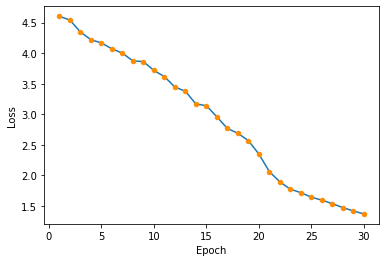

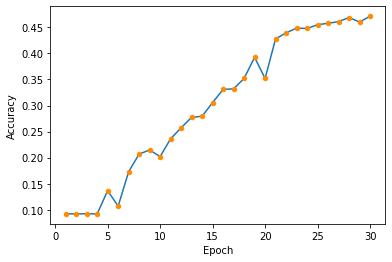

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = np.arange(1, NUM_EPOCHS+1)
plt.figure()
plt.scatter(epochs, losses, c="darkorange", s=20)
plt.plot(epochs, losses, zorder=-1)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.scatter(epochs, accuracies, c="darkorange", s=20)
plt.plot(epochs, accuracies, zorder=-1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

**Validation**

In [54]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:07<00:00,  1.65it/s]

Validation Accuracy: 0.47130013831258644


**Test**

In [55]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Test Accuracy: 0.47701348081576217
